In [27]:
pip install holidays


Note: you may need to restart the kernel to use updated packages.


In [75]:
#  Imports & Setup
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
import warnings

warnings.filterwarnings("ignore")


In [77]:
# Load & Preprocess Dataset

df = pd.read_csv(r"C:\Users\USER\Chameleon AI-IoT\MOP-Code\artificial-intelligence\Traffic Analysis\LSTM-GRU Vehicle Traffic\datasets\lstm_ready_traffic_data.csv")
df['datetime'] = pd.to_datetime(df['datetime'])

# Focus on datetime and target
df = df[['datetime', 'Total_Traffic_Volume']].copy()

# Resample to hourly and forward-fill
df = df.set_index('datetime').resample('H').mean().fillna(method='ffill').reset_index()

# Split index for 80/20 split
split_idx = int(len(df) * 0.8)

# Create a clean copy for ARIMA use
df_arima = df.copy()


In [78]:
# ----------------------------------
# Step 3: Prophet Implementation
# ----------------------------------
# Rename columns for Prophet
df_prophet = df.rename(columns={'datetime': 'ds', 'Total_Traffic_Volume': 'y'})

# Split
train_prophet = df_prophet.iloc[:split_idx]
test_prophet = df_prophet.iloc[split_idx:]

# Initialize and add AU holidays
prophet_model = Prophet()
prophet_model.add_country_holidays(country_name='AU')

# Fit model
prophet_model.fit(train_prophet)

# Forecast
future = test_prophet[['ds']]
forecast = prophet_model.predict(future)

# Evaluation
y_true = test_prophet['y'].values
y_pred = forecast['yhat'].values

rmse_prophet = np.sqrt(mean_squared_error(y_true, y_pred))
mae_prophet = mean_absolute_error(y_true, y_pred)
r2_prophet = r2_score(y_true, y_pred)

print("📈 Prophet Results:")
print(f"RMSE: {rmse_prophet:.2f}")
print(f"MAE : {mae_prophet:.2f}")
print(f"R²  : {r2_prophet:.4f}")


20:40:21 - cmdstanpy - INFO - Chain [1] start processing
20:41:00 - cmdstanpy - INFO - Chain [1] done processing


📈 Prophet Results:
RMSE: 91.89
MAE : 77.92
R²  : -1.6379


In [80]:
# -------------------------------
# Step 4: ARIMA Implementation
# -------------------------------
# Prepare ARIMA data
df_arima = df_arima.set_index('datetime')
train_arima = df_arima.iloc[:split_idx]
test_arima = df_arima.iloc[split_idx:]

# Fit ARIMA model (chosen order)
arima_model = ARIMA(train_arima, order=(4, 1, 5))
arima_result = arima_model.fit()

# Forecast
forecast_arima = arima_result.forecast(steps=len(test_arima))

# Evaluation
rmse_arima = np.sqrt(mean_squared_error(test_arima, forecast_arima))
mae_arima = mean_absolute_error(test_arima, forecast_arima)
r2_arima = r2_score(test_arima, forecast_arima)

print("\n📉 ARIMA Results:")
print(f"RMSE: {rmse_arima:.2f}")
print(f"MAE : {mae_arima:.2f}")
print(f"R²  : {r2_arima:.4f}")



📉 ARIMA Results:
RMSE: 60.00
MAE : 42.96
R²  : -0.1247


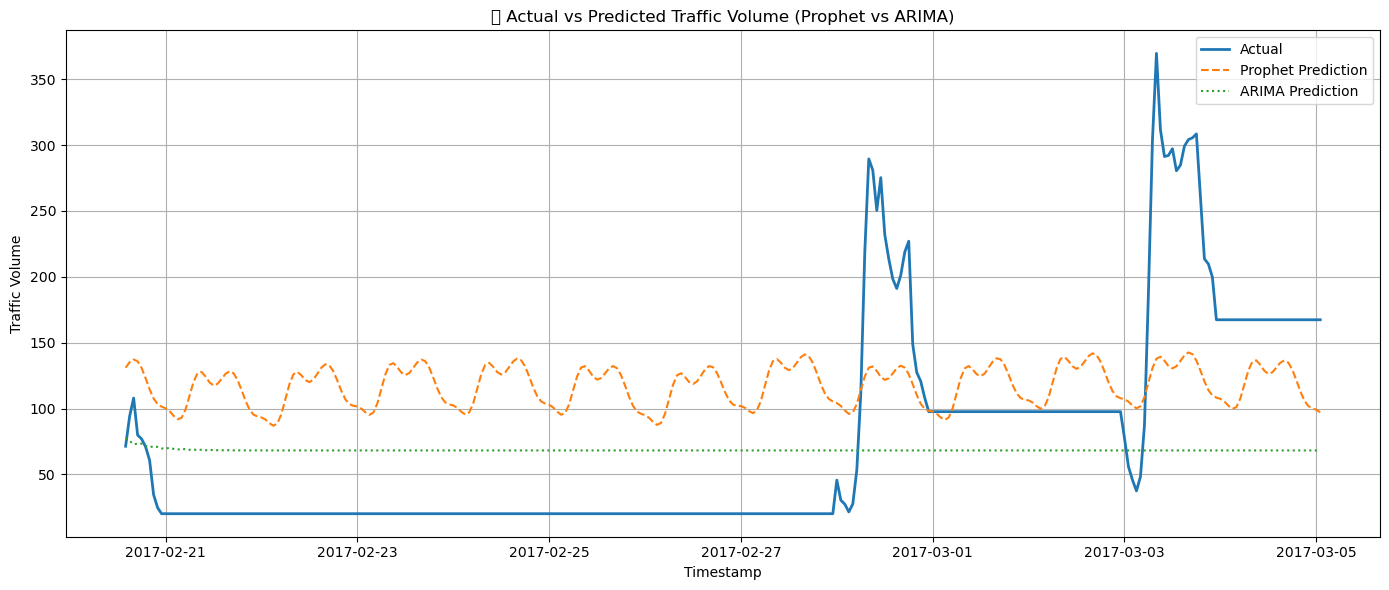

In [81]:
import matplotlib.pyplot as plt

# Trim to same length and create time index for plotting
time_index = test_prophet['ds'].values[:300]
actual = y_true[:300]
predicted_prophet = y_pred[:300]
predicted_arima = forecast_arima[:300]

# Plot
plt.figure(figsize=(14, 6))
plt.plot(time_index, actual, label='Actual', linewidth=2)
plt.plot(time_index, predicted_prophet, label='Prophet Prediction', linestyle='--')
plt.plot(time_index, predicted_arima, label='ARIMA Prediction', linestyle=':')
plt.xlabel("Timestamp")
plt.ylabel("Traffic Volume")
plt.title("📊 Actual vs Predicted Traffic Volume (Prophet vs ARIMA)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


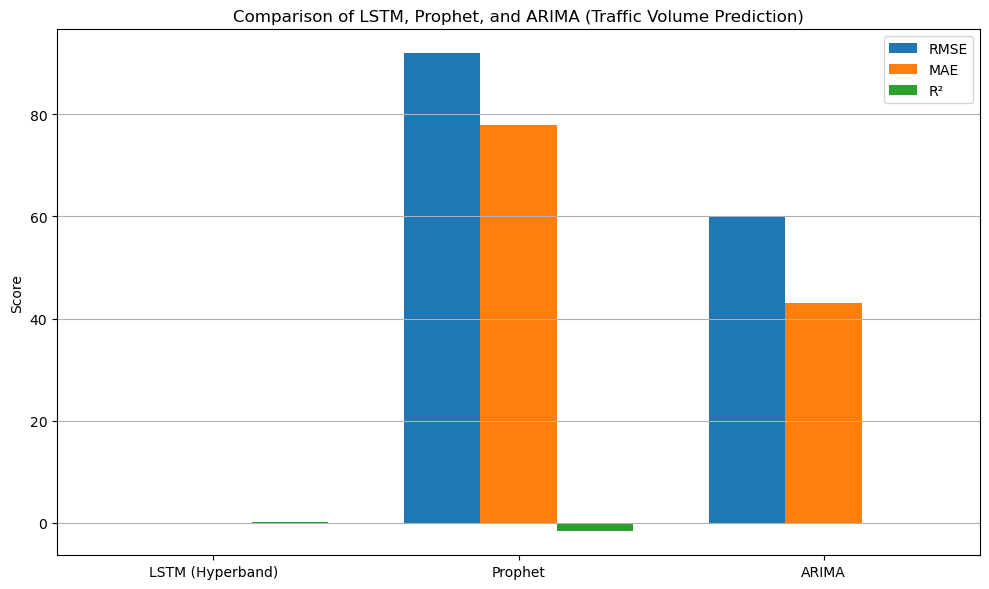

In [82]:
import matplotlib.pyplot as plt
import pandas as pd

# Manually compiled scores
comparison_data = {
    'Model': ['LSTM (Bayesian_ts=15)', 'Prophet', 'ARIMA'],
    'RMSE': [0.0806, 91.89, 60.00],
    'MAE': [0.0501, 77.92, 42.96],
    'R2': [0.1478, -1.6379, -0.1247]
}

df_comparison = pd.DataFrame(comparison_data)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.25
x = range(len(df_comparison['Model']))

# Plot each metric
plt.bar([i - bar_width for i in x], df_comparison['RMSE'], width=bar_width, label='RMSE')
plt.bar(x, df_comparison['MAE'], width=bar_width, label='MAE')
plt.bar([i + bar_width for i in x], df_comparison['R2'], width=bar_width, label='R²')

# Labeling
plt.xticks(x, df_comparison['Model'])
plt.title('Comparison of LSTM, Prophet, and ARIMA (Traffic Volume Prediction)')
plt.ylabel('Score')
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [87]:
np.save(r"C:\Users\USER\Chameleon AI-IoT\MOP-Code\artificial-intelligence\Traffic Analysis\LSTM-GRU Vehicle Traffic\traffic_dashboard\data/y_arima.npy", forecast_arima)
np.save(r"C:\Users\USER\Chameleon AI-IoT\MOP-Code\artificial-intelligence\Traffic Analysis\LSTM-GRU Vehicle Traffic\traffic_dashboard\data/y_prophet.npy", y_pred)